In [202]:
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.matlib

from skimage.transform import iradon
import nibabel as nib
import radontea as rt

In [2]:
image = np.load('abs_mask.npy')


# Load single cell:
image = image[0:16,:,:]

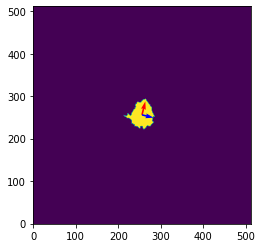

In [127]:
# Perform statistics on 3rd slice (0 indexed):
img = image[3]

x_ind = np.linspace(0, np.shape(img)[0] - 1, np.shape(img)[0])
y_ind = np.linspace(0, np.shape(img)[1] - 1, np.shape(img)[1])
x_ind = np.matlib.repmat(x_ind, np.shape(img)[1], 1)
x_ind = np.transpose(x_ind)
y_ind = np.matlib.repmat(y_ind, np.shape(img)[0], 1)

# Find the mean vector:
mean_x = np.sum(x_ind * img) / np.sum(img)
mean_y = np.sum(y_ind * img) / np.sum(img)

# Observe that these are approximately the mean locations:
mu = np.array([mean_x, mean_y])

Sigma = np.zeros((2, 2))

# Variance of x:
S11 = np.sum(x_ind * x_ind * img) / np.sum(img) - mu[0]*mu[0]

# Covariance of x and y:
S12 = np.sum(x_ind * y_ind * img) / np.sum(img) - mu[0]*mu[1]

# Variance of y:
S22 = np.sum(y_ind * y_ind * img) / np.sum(img) - mu[1]*mu[1]

# Correlation matrix:
Sigma[0, 0] = S11
Sigma[0, 1] = S12
Sigma[1, 0] = S12
Sigma[1, 1] = S22

L, Q = np.linalg.eig(Sigma)

# Roll the matrix so that it is centered at (256, 256)
r_quantities = np.array([256, 256]) - np.round(mu)
r_quantities = r_quantities.astype(int)
img = np.roll(np.roll(img, r_quantities[0], axis=0), r_quantities[1], axis=1)

origin = np.array([[256, 256],[256, 256]]) # origin point

plt.imshow(img, origin="lower")
# Use 2 std deviations because it is approx 95%
v1 = 2*np.sqrt(L[0])*Q[:,0]
v2 = 2*np.sqrt(L[1])*Q[:,1]
plt.quiver(np.array([256,256]), np.array([256,256]), np.array([v1[1],v2[1]]), np.array([v1[0],v2[0]]), color=['r','b'], angles='xy', scale_units='xy', scale=1)

In [83]:
lambdas_lower = list()
lambdas_upper = list()

centers = list()

N_z = 16

for i in range(N_z):

    # Perform statistics on ith slice:
    img = image[i]

    x_ind = np.linspace(0, np.shape(img)[0] - 1, np.shape(img)[0])
    y_ind = np.linspace(0, np.shape(img)[1] - 1, np.shape(img)[1])
    x_ind = np.matlib.repmat(x_ind, np.shape(img)[1], 1)
    x_ind = np.transpose(x_ind)
    y_ind = np.matlib.repmat(y_ind, np.shape(img)[0], 1)

    # Find the mean vector:
    mean_x = np.sum(x_ind * img) / np.sum(img)
    mean_y = np.sum(y_ind * img) / np.sum(img)

    # Observe that these are approximately the mean locations:
    mu = np.array([mean_x, mean_y])

    centers.append(mu)
    
    Sigma = np.zeros((2, 2))

    # Variance of x:
    S11 = np.sum(x_ind * x_ind * img) / np.sum(img) - mu[0]*mu[0]

    # Covariance of x and y:
    S12 = np.sum(x_ind * y_ind * img) / np.sum(img) - mu[0]*mu[1]

    # Variance of y:
    S22 = np.sum(y_ind * y_ind * img) / np.sum(img) - mu[1]*mu[1]

    # Correlation matrix:
    Sigma[0, 0] = S11
    Sigma[0, 1] = S12
    Sigma[1, 0] = S12
    Sigma[1, 1] = S22

    L, Q = np.linalg.eig(Sigma)

    # Roll the matrix so that it is centered at (256, 256)
    r_quantities = np.array([256, 256]) - np.round(mu)
    r_quantities = r_quantities.astype(int)
    # Save the rolled image in our stack:
    image[i] = np.roll(np.roll(img, r_quantities[0], axis=0), r_quantities[1], axis=1)
        
    l1 = 2*np.sqrt(L[0])
    l2 = 2*np.sqrt(L[1])
    
    # Use 2 std deviations because it is approx 95%
    lambdas_lower.append(min(l1,l2))
    lambdas_upper.append(max(l1,l2))

(array([1., 0., 2., 1., 0., 1., 0., 4., 5., 2.]),
 array([21.33687914, 22.15980654, 22.98273393, 23.80566133, 24.62858872,
        25.45151612, 26.27444351, 27.09737091, 27.92029831, 28.7432257 ,
        29.5661531 ]),
 <BarContainer object of 10 artists>)

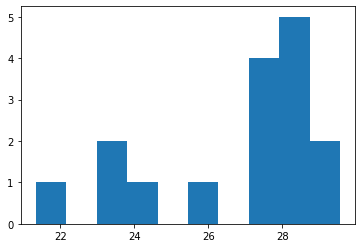

In [5]:
plt.hist(lambdas_lower)

(array([1., 2., 1., 1., 1., 1., 4., 1., 2., 2.]),
 array([31.4412911 , 32.15064616, 32.86000122, 33.56935627, 34.27871133,
        34.98806639, 35.69742145, 36.40677651, 37.11613156, 37.82548662,
        38.53484168]),
 <BarContainer object of 10 artists>)

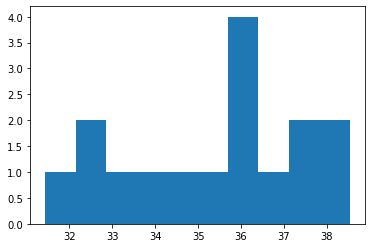

In [6]:
plt.hist(lambdas_upper)

In [135]:
# From the top two histograms, approximate ball scalings as: 36.40677651 x 28.7432257 x 22.98273393

x_bound = 36.40677651
y_bound = 28.7432257
z_bound = 22.98273393

d_theta = np.pi / 16
theta = np.arange(0, np.pi, d_theta)

d_phi = np.pi / 16
phi = np.arange(0, np.pi / 2, d_phi)

# Form an ellipsoid with these dimensions:
# (x / x_bound)^2 + (y / y_bound)^2 + (z / z_bound)^2 <= 1

x_size, y_size = np.shape(image[0])

projections = np.zeros((np.size(theta), np.size(phi), x_size, y_size))

t_ind = -1
p_ind = -1

projection = np.zeros((x_size, y_size))

for t in theta:
    t_ind = t_ind + 1
    p_ind = -1
    print(t)
    for p in phi:
        p_ind = p_ind + 1
        for x in np.arange(int(-x_size / 2), int(x_size / 2), 1):
            for y in np.arange(int(-y_size / 2), int(y_size / 2), 1):
                # Rotate by t:
                x_ = x*np.cos(t) - y*np.sin(t)
                y_ = x*np.sin(t) + y*np.cos(t)

                # Rotate by phi (z = 0):
                z_ = x_ * np.sin(p)
                                
                if( (x_/x_bound)**2 + (y_/y_bound)**2 + (z_/z_bound)**2 < 1):
                    projection[x + 256, y + 256] = 1
                else:
                    projection[x + 256, y + 256] = 0
        projections[t_ind, p_ind, :, :] = projection
                    

0.0
0.19634954084936207
0.39269908169872414
0.5890486225480862
0.7853981633974483
0.9817477042468103
1.1780972450961724
1.3744467859455345
1.5707963267948966
1.7671458676442586
1.9634954084936207
2.1598449493429825
2.356194490192345
2.552544031041707
2.748893571891069
2.945243112740431


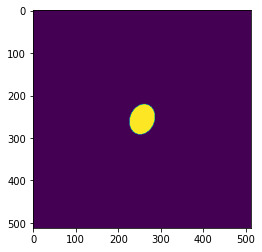

In [130]:
plt.imshow(projections[1,0,:,:])

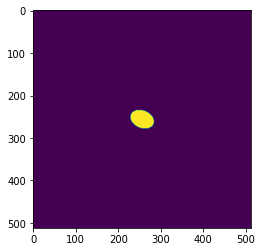

In [131]:
plt.imshow(projections[1,3,:,:])

In [136]:
# Form angle_arr[time] = [theta_angle, phi_angle], THEN perform Viterbi Algorithm for most accurate phase trajectory:
angle_arr = np.zeros((N_z, 2))

#plt.imshow(image[9,:,:])
#plt.imshow(projections[1,3,:,:] * image[9,:,:])

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

best_corr = -math.inf

for i in range(N_z):
    for t_ind in range(np.size(theta)):
        for p_ind in range(np.size(phi)):
            correlation = corr2(projections[t_ind, p_ind, :, :], image[i, :, :])
            if(correlation > best_corr):
                best_corr = correlation
                angle_arr[i, 0] = theta[t_ind]
                angle_arr[i, 1] = phi[p_ind]
    # At the next time slice, reset the best correlation to -inf:
    best_corr = -math.inf    

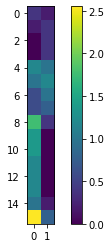

In [137]:
plt.imshow(angle_arr)
plt.colorbar()

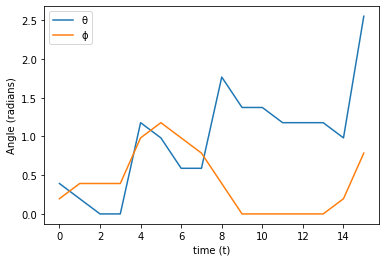

In [226]:
plt.plot(angle_arr[:,0], label = "θ")
plt.plot(angle_arr[:,1], label = "ϕ")
plt.xlabel("time (t)")
plt.ylabel("Angle (radians)")
plt.legend()

In [205]:
np.shape(image)

(16, 512, 512)

In [206]:
np.shape(theta)

(16,)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


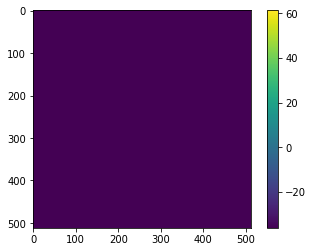

In [224]:
plt.imshow(output[5])
plt.colorbar()

(output != 0).any()


image2 = np.zeros((512,512,512))
for i in range(np.shape(image)[0]):
    print(i)
    
    # FOR NOW: Rotate the images backwards by theta (in the future we will use Viterbi to correct instead)
    # Todo....    
    
    sinogram = np.zeros((512,512))
    theta_ = np.linspace(0., 180., 512, endpoint=False)
    
    # Because of d_theta, these move in increments of 32:
    for j in np.arange(0,512,32):
        sinogram[:, j] = image[i, int(j / 32), :]
    
    # sinogram = radon(image_i, theta=theta)

    # Suppose we lost every even degree's sample:
    #for j in range(160):
     #   if j%2==0:
      #      sinogram[:,j] = 0

    #sinogram[:,6:30] = 0
    #sinogram[:,130:150] = 0

    # Get rid of frequency detail because we ONLY care about the boundary:
    # sinogram[sinogram != 0] = 1
    
    # Smooth the image
   # sinogram = scipy.ndimage.gaussian_filter(sinogram, 1)

    # Threshold so it is still a mask:
    #sinogram[sinogram < 0.5] = 0
    #sinogram[sinogram >= 0.5] = 1

    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
    image2[:,:,i] = reconstruction_fbp
    
nib.save(nib.Nifti1Image(image2,np.eye(4)),"output.nii.gz")


#image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)


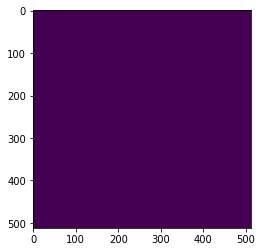

In [223]:
plt.imshow(sinogram)

In [171]:
np.shape(angle_arr)

(16, 2)